In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


여기서 볼 수 있듯이 404개의 훈련 샘플과 102개의 테스트 샘플이 있고 모두 13개의 수치 특성을 가지고 있습니다. 13개의 특성은 다음과 같습니다:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

타깃은 주택의 중간 가격으로 천달러 단위입니다:

In [3]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [5]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

이 네트워크의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없습니다(선형 층이라고 합니다). 이것이 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성입니다. 활성화 함수를 적용하면 출력 값의 범위를 제한하게 됩니다. 예를 들어 마지막 층에 `sigmoid` 활성화 함수를 적용하면 네트워크가 0과 1 사이의 값을 예측하도록 학습될 것입니다. 여기서는 마지막 층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습됩니다.

이 모델은 `mse` 손실 함수를 사용하여 컴파일합니다. 이 함수는 평균 제곱 오차(mean squared error)의 약자로 예측과 타깃 사이 거리의 제곱입니다. 회귀 문제에서 널리 사용되는 손실 함수입니다.

훈련하는 동안 모니터링을 위해 새로운 지표인 평균 절대 오차를 측정합니다. 이는 예측과 타깃 사이 거리의 절댓값입니다. 예를 들어 이 예제에서 MAE가 0.5이면 예측이 평균적으로 $500 정도 차이가 난다는 뜻입니다.

In [6]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('처리중인 폴드 #', i)
  
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  
  val_mse, val_mae = model.evaluate(val_data, val_targets)
  all_scores.append(val_mae)

처리중인 폴드 # 0
101/101 [==============================] - 0s 257us/step
처리중인 폴드 # 1
101/101 [==============================] - 0s 257us/step
처리중인 폴드 # 2
101/101 [==============================] - 0s 238us/step
처리중인 폴드 # 3
101/101 [==============================] - 0s 257us/step


In [7]:
print(all_scores)

[2.270967960357666, 2.6974740028381348, 2.7548470497131348, 2.530268907546997]


In [8]:
np.mean(all_scores)

2.563389480113983

In [9]:
from keras import backend as K

K.clear_session()

In [11]:
num_epochs = 500
all_histories = []
all_mae_histories = []

for i in range(k):
  print('처리중인 폴드 #', i)
  
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
  
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  all_histories.append(history)  

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [15]:
print(all_histories[0].history['mae'])

[10.610287, 3.6188223, 2.991727, 2.7571115, 2.6225646, 2.5442994, 2.494766, 2.302675, 2.3253129, 2.2964277, 2.2314792, 2.2018406, 2.193116, 2.2153301, 2.1248708, 2.0854435, 2.101798, 2.0268981, 1.9993306, 2.0326335, 1.9796373, 2.0331233, 2.0190737, 1.9942305, 1.933069, 1.9216338, 1.8996167, 1.9412842, 1.9157119, 1.8509258, 1.8373028, 1.818669, 1.8655334, 1.8035218, 1.7559876, 1.8102937, 1.8168384, 1.7509854, 1.808121, 1.7751558, 1.6877983, 1.7778571, 1.7828081, 1.6497761, 1.6895725, 1.7114936, 1.7454151, 1.6869093, 1.7082365, 1.6851317, 1.6287557, 1.6287695, 1.5575689, 1.5955317, 1.6183202, 1.5547814, 1.6167036, 1.5692239, 1.6063169, 1.5704781, 1.5822767, 1.5748807, 1.5802784, 1.5661829, 1.5218263, 1.5229337, 1.517059, 1.5538781, 1.5476843, 1.5320821, 1.4716806, 1.5096467, 1.4694263, 1.471567, 1.40169, 1.4886129, 1.4721599, 1.441077, 1.4073977, 1.4634994, 1.5101758, 1.472938, 1.3786689, 1.383953, 1.454169, 1.4207247, 1.4418745, 1.4522369, 1.4193774, 1.3856404, 1.3912052, 1.437999, 1.38

In [16]:
average_mae_history = [np.mean([history.history['mae'][i] for history in all_histories]) for i in range(num_epochs)]

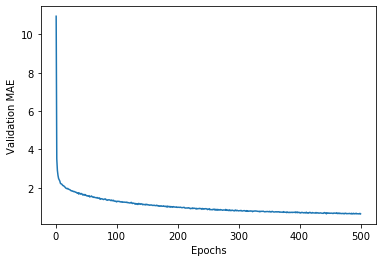

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [18]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)

* 곡선의 다른 부분과 스케일이 많이 다른 첫 10개 데이터 포인트를 제외시킵니다.
* 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체합니다.

In [19]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

TypeError: object of type 'NoneType' has no len()